# Efficient moving obstacle constraint adding when doing MILP planning

In [1]:
import sys
sys.path.append('../')
from panav.env import NavigationEnv, Box2DRegion, box_2d_center, PolygonRegion
from panav.hybrid import HybridGraph
from panav.viz import draw_hybrid

from panav.TrafficAwarePlanning import traffic_aware_HG_plan
from panav.SAMP import Tube_Planning

import numpy as np
from matplotlib import pyplot as plt

%load_ext autoreload
%autoreload 2

## Empty environment

In [175]:

# 2D navigation environment

start_box_side = np.array([1,1])
goal_box_side = np.array([1,1])

top, bottom = 8,-8
start_x_offset = 6
goal_x_offset = 8
N = 4

start_locs = np.vstack([
np.vstack([np.ones(N)*start_x_offset,np.linspace(top,bottom, N)]).T,
np.vstack([np.ones(N)*(-start_x_offset),np.linspace(top,bottom, N)]).T])

goal_locs = np.vstack([
np.vstack([np.ones(N)*(-goal_x_offset),np.linspace(bottom,top, N)]).T,
np.vstack([np.ones(N)*goal_x_offset,np.linspace(bottom,top, N)]).T])


starts = [box_2d_center(s,start_box_side) for s in start_locs]
goals = [box_2d_center(g,goal_box_side) for g in goal_locs]

start = np.array(list(starts[0].centroid().coords)[0])
goal = np.array(list(goals[0].centroid().coords)[0])

limits = [(-10.0,10.0),(-10.0,10.0)]

bloating_r = 0.5 
env = NavigationEnv(limits,[],starts,goals)

# Multi-tunnel Environment

In [176]:
y_min,y_max = min(limits[1]),max(limits[1])
n_tunnel = 2
w = 2*bloating_r # Tunnel width
s = (y_max-y_min-w*n_tunnel)/(n_tunnel+1) # Spacing between tunnels

d = 5 # Thickness of the wall

obstacles = []
for i in range(n_tunnel+1):
    side = np.array([d,s])
    center = np.array([0, y_max-s/2-i*(s+w)])
    obstacles.append(box_2d_center(center,side))
env.obstacles = obstacles



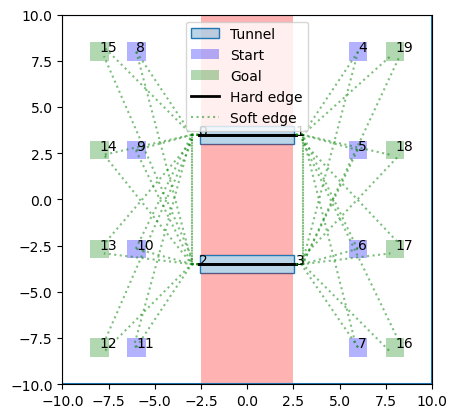

In [177]:
HG = HybridGraph(env,bloating_r)
ax = plt.gca()
draw_hybrid(HG,ax,display_soft=True,display_node=True)
plt.show()    

In [178]:
paths = traffic_aware_HG_plan(HG)

In [179]:
from panav.util import unique_tx

vmax = 1.0
continuous_plans = []

from panav.SAMP import lazy_optim,auto_K_tube_planning,Efficient_Tube_Planning
# planner = lambda env,start,goal,tube_obs: Tube_Planning(env,start,goal,vmax,bloating_r,K=5, tube_obs=tube_obs)
planner = lambda env,start,goal,tube_obs: auto_K_tube_planning(env,start,goal,vmax,bloating_r,tube_obs=tube_obs)

for i,path in enumerate(paths):
    print("Planning for {}/{}".format(i,len(paths)))
    start = HG.node_loc(path[0])
    goal = HG.node_loc(path[-1])
    p = Efficient_Tube_Planning(HG.env,start,goal,vmax,bloating_r,continuous_plans)
    # p = lazy_optim(planner,HG.env,start,goal,continuous_plans,bloating_r)

    # p = auto_K_tube_planning(HG.env,start,goal,vmax,bloating_r,obs_trajectories=continuous_plans)
    continuous_plans.append(p)


Planning for 0/8
Planning for 1/8
Planning for 2/8
Planning for 3/8
Planning for 4/8
Planning for 5/8
Planning for 6/8
Planning for 7/8


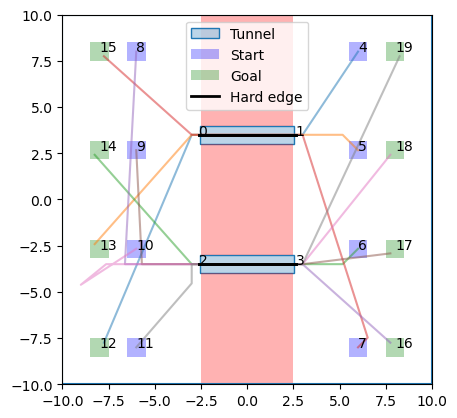

In [180]:
draw_hybrid(HG,ax=plt.gca(),paths = [o[1] for o in continuous_plans if o])